# Import from Github

In [15]:
'''No need to download anything locally except this notebook'''
# --- Bootstrap: pull repo, import models, load DIAS pickle into `hand_data2` ---

import sys, subprocess, pickle
from pathlib import Path

REPO = "yoannmorello/Bayesian_Result_Model"
REPO_DIR = Path("Bayesian_Result_Model")

# 1) Get the repo (so notebook runs anywhere)
if not REPO_DIR.exists():
    subprocess.run(
        ["git", "clone", "--depth", "1", f"https://github.com/{REPO}.git"],
        check=True
    )

# 2) Make package importable
if str(REPO_DIR) not in sys.path:
    sys.path.insert(0, str(REPO_DIR))

# 3) Import the paper’s four models
from bayesrm.all_models import (
    MonotonicModel,
    MonotonicStrictBinary,
    MonotonicMajorityBinary,
    MonotonicBayesIndividualMajority,
    MonotonicBayesIndividualLogOddsNoClipPriorChainMC1,
)



# 4) Load DIAS data into `hand_data2`
DATA_PATH = REPO_DIR / "data" / "annotation_sets_gold (1)_HAND_HAND_HAND_HAND.pkl"
with open(DATA_PATH, "rb") as f:
    hand_data2 = pickle.load(f)

print("Loaded hand_data2:", type(hand_data2), "length:",
      (len(hand_data2) if hasattr(hand_data2, "__len__") else "n/a"))


Loaded hand_data2: <class 'dict'> length: 201


# Data Exploration

In [3]:
# --- quick summary of class balance ---------------------------------
n_pi    = sum(1 for v in hand_data2.values() if v["conclusion"] == 'pi')
n_delta = sum(1 for v in hand_data2.values() if v["conclusion"] == 'delta')
n_total = n_pi + n_delta

print(f"π cases   : {n_pi:3d}  ({n_pi / n_total:6.2%})")
print(f"δ cases   : {n_delta:3d}  ({n_delta / n_total:6.2%})")
print(f"total     : {n_total:3d}")


π cases   : 125  (62.19%)
δ cases   :  76  (37.81%)
total     : 201


#Individual Betas for Naive Bayes

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_pdf

EPS_BETA = 1e-9  # tiny guard: valid Beta with no +1 smoothing

def _per_precedent_counts_no_plus1(target_info, train_db):
    """
    Compute (alpha, beta) = (r, s) for one precedent *without* +1 smoothing.
    For a π precedent with set S: compare to SUPERSets of S.
      r = # { π partners }, s = # { δ partners } among {T ⊇ S}.
    For a δ precedent with set S: compare to SUBSets of S.
      r = # { δ partners }, s = # { π partners } among {T ⊆ S}.
    """
    S = target_info["set"]
    conc = target_info["conclusion"]
    r = s = 0.0
    if conc == "pi":
        for v in train_db.values():
            if v["set"].issuperset(S):
                if v["conclusion"] == "pi":
                    r += 1.0
                else:
                    s += 1.0
    else:  # conc == "delta"
        for v in train_db.values():
            if v["set"].issubset(S):
                if v["conclusion"] == "delta":
                    r += 1.0
                else:
                    s += 1.0
    # no +1: use tiny epsilon so Betas are well-defined
    return max(r, EPS_BETA), max(s, EPS_BETA)

def _applicable_candidates(case_set, train_db):
    """Gather applicable π-subsets and δ-supersets (with their sets and infos)."""
    pi_cands  = []
    del_cands = []
    for cid, info in train_db.items():
        S, dec = info["set"], info["conclusion"]
        if dec == "pi" and S.issubset(case_set):
            pi_cands.append((cid, S, info))
        elif dec == "delta" and S.issuperset(case_set):
            del_cands.append((cid, S, info))
    return pi_cands, del_cands

def _chain_prune_max_pi_min_delta(pi_cands, del_cands):
    """
    π side: keep only **maximal** subsets (remove strict subsets).
    δ side: keep only **minimal** supersets (remove strict supersets).
    Return the pruned lists (preserving input order for stability).
    """
    # π: drop any cand whose set is a strict subset of another π-cand's set
    keep_pi = [True] * len(pi_cands)
    for i, (_, Si, _) in enumerate(pi_cands):
        for j, (_, Sj, _) in enumerate(pi_cands):
            if i != j and Si < Sj:
                keep_pi[i] = False
                break
    pruned_pi = [pi_cands[i] for i in range(len(pi_cands)) if keep_pi[i]]

    # δ: drop any cand whose set is a strict *superset* of another δ-cand's set
    keep_de = [True] * len(del_cands)
    for i, (_, Si, _) in enumerate(del_cands):
        for j, (_, Sj, _) in enumerate(del_cands):
            if i != j and Sj < Si:  # another is strictly smaller (closer to X)
                keep_de[i] = False
                break
    pruned_de = [del_cands[i] for i in range(len(del_cands)) if keep_de[i]]
    return pruned_pi, pruned_de

def plot_logodds_chain_prior_mc1_betas(case_id: str, db: dict) -> None:
    """
    Plot the per-precedent Beta PDFs used by the Log-Odds Chain+Prior MC1 model
    (unweighted, no +1 in (α,β)). Case <case_id> is left out for a LOO view.

    Left column: π precedents kept after chain pruning (maximal π-subsets).
    Right column: δ precedents kept after chain pruning (minimal δ-supersets).
    """
    if case_id not in db:
        raise KeyError(f"Unknown case_id: {case_id}")

    # Leave-one-out training DB and target set
    train_db = {cid: info for cid, info in db.items() if cid != case_id}
    tgt_set  = db[case_id]["set"]

    # Collect applicable candidates
    pi_cands, del_cands = _applicable_candidates(tgt_set, train_db)

    # Chain prune: maximal π-subsets, minimal δ-supersets
    pi_pruned, del_pruned = _chain_prune_max_pi_min_delta(pi_cands, del_cands)

    # Build per-precedent Betas (no +1, eps guard)
    pi_betas = []
    for _, _, info in pi_pruned:
        a, b = _per_precedent_counts_no_plus1(info, train_db)
        pi_betas.append((a, b))
    del_betas = []
    for _, _, info in del_pruned:
        a, b = _per_precedent_counts_no_plus1(info, train_db)
        del_betas.append((a, b))

    n_rows = max(len(pi_betas), len(del_betas))
    if n_rows == 0:
        print("No (chain-pruned) applicable precedents for this case.")
        return

    # Plot (original grid: n_rows x 2; left=π, right=δ)
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(8, 2.0 * n_rows),
        sharex=True, sharey=True, squeeze=False
    )
    x = np.linspace(0, 1, 400)

    for r in range(n_rows):
        # π column (left)
        ax = axes[r, 0]
        if r < len(pi_betas):
            a, b = pi_betas[r]
            ax.plot(x, beta_pdf.pdf(x, a, b),"")
            mu = a / (a + b)
            ax.text(0.98, 0.90, fr"$\mu={mu:.2f}$", ha="right", va="top", transform=ax.transAxes, fontsize=9)
        else:
            ax.set_axis_off()
        ax.set_ylabel(fr"$f^{{\pi}}_{{{r+1}}}$", fontsize=10)
        ax.set_xlim(0.5, 1.0)  # start x-axis at 0.5

        # δ column (right)
        ax = axes[r, 1]
        if r < len(del_betas):
            a, b = del_betas[r]
            ax.plot(x, beta_pdf.pdf(x, a, b), label="LogOdds Chain+Prior (no +1)" if r == 0 else "")
            mu = a / (a + b)
            ax.text(0.98, 0.90, fr"$\mu={mu:.2f}$", ha="right", va="top", transform=ax.transAxes, fontsize=9)
        else:
            ax.set_axis_off()
        ax.set_ylabel(fr"$f^{{\delta}}_{{{r+1}}}$", fontsize=10)
        ax.set_xlim(0.5, 1.0)  # start x-axis at 0.5

    # Column titles (keep); no main/super title
    axes[0, 0].set_title("π precedents (chain-pruned)", fontsize=12)
    axes[0, 1].set_title("δ precedents (chain-pruned)", fontsize=12)

    # Legend (optional)
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=1, frameon=False)

    plt.tight_layout()
    plt.savefig(f"per_precedent_betas_{case_id}.png", dpi=300, bbox_inches="tight")
    plt.show()



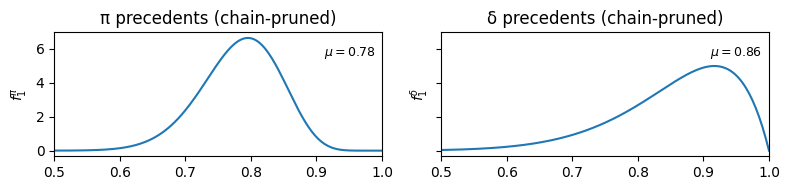

In [7]:
plot_logodds_chain_prior_mc1_betas("state_v_huntley_100172.txt", hand_data2)

#Plot conflicting predictions

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import itertools
from pathlib import Path

def _parse_prediction(out):
    side = np.nan
    conf = np.nan
    if isinstance(out, tuple):
        if len(out) >= 1:
            side = out[0]
        if len(out) >= 2 and isinstance(out[1], (int, float, np.floating)):
            conf = float(out[1])
    else:
        side = out
        if isinstance(side, str):
            conf = 1.0
    if side not in ("pi", "delta"):
        side = np.nan
    return side, conf

def _precedent_counts_for_case(data, case_name):
    X = data[case_name]["set"]
    n_pi = n_del = 0
    for other, info in data.items():
        if other == case_name:
            continue
        S, dec = info["set"], info["conclusion"]
        if dec == "pi" and S.issubset(X):
            n_pi += 1
        if dec == "delta" and S.issuperset(X):
            n_del += 1
    return n_pi, n_del

def plot_model_disagreement_with_precedents(
    data: dict,
    model_classes: list,
    *,
    confidence: float | None = None,
    sort_by: str = "disagreements",   # {'disagreements','name','pi_prec','delta_prec'}
    max_cases: int | None = None,     # cap per panel after filtering
    figsize=(14, 6),
    jitter: float = 0.35,             # horizontal jitter for model markers
    bar_alpha: float = 0.35,          # transparency for precedent bars (disabled for EPS)
    marker_size: int = 70,            # marker size for model predictions
    model_marker_map: dict[str, str] | None = None,  # {ModelName: matplotlib marker}
    marker_cycle: tuple = ("o","s","^","D","v","P","X","*","<",">","h","p","d"),
    save_path: str = "models_on_conflicts.png",
    show: bool = True,
    close_after: bool = True,
):
    """
    Left panel (true π):  +π bars / −δ bars; model preds: π→+conf, δ→−conf
    Right panel (true δ): +δ bars / −π bars; model preds: δ→+conf, π→−conf
    """
    cases = list(data.keys())
    true_side = {c: data[c]["conclusion"] for c in cases}
    for c in cases:
        if true_side[c] not in ("pi", "delta"):
            raise ValueError(f"Case {c} has non-normalized conclusion: {true_side[c]}")

    # detect EPS to avoid transparency
    ext = Path(save_path).suffix.lower()
    is_eps = ext in {".eps", ".ps"}

    # softer, print-friendly colors (no alpha needed)
    soft_blue = "#9ecae1"
    soft_red  = "#fcae91"

    # Build stable name list and marker assignment
    model_names = [M.__name__ for M in model_classes]
    if model_marker_map is None:
        mm = {}
        cyc = list(marker_cycle)
        for i, name in enumerate(sorted(model_names)):
            mm[name] = cyc[i % len(cyc)]
        model_marker_map = mm
    else:
        mm = dict(model_marker_map)
        cyc = list(marker_cycle)
        i = 0
        for name in model_names:
            if name not in mm:
                mm[name] = cyc[i % len(cyc)]
                i += 1
        model_marker_map = mm

    rows = []
    for i, cid in enumerate(cases):
        # LOO split
        train_db = {cases[j]: data[cases[j]] for j in range(len(cases)) if j != i}
        test_case = data[cid]

        # precedent counts (vs all other cases)
        pi_prec, del_prec = _precedent_counts_for_case(data, cid)

        # model predictions
        preds = {}
        for M in model_classes:
            m = M()
            m.fit(train_db)
            out = m.predict(test_case)
            side, conf = _parse_prediction(out)
            if confidence is not None:
                if not (isinstance(conf, (int, float, np.floating)) and conf >= confidence):
                    side = np.nan
            preds[M.__name__] = (side, float(conf) if isinstance(conf, (int, float, np.floating)) else np.nan)

        # disagreement count
        dcount = 0
        for a, b in itertools.combinations(model_names, 2):
            sa, _ = preds[a]
            sb, _ = preds[b]
            a_nan, b_nan = pd.isna(sa), pd.isna(sb)
            if a_nan and b_nan:
                continue
            if a_nan ^ b_nan or sa != sb:
                dcount += 1
        if dcount == 0:
            continue

        rec = {"case": cid, "true": true_side[cid],
               "pi_prec": pi_prec, "delta_prec": del_prec,
               "disagree_count": dcount}
        for name in model_names:
            side, conf = preds[name]
            rec[name] = (side, conf)
            rec[f"{name}_side"] = side
            rec[f"{name}_conf"] = conf
        rows.append(rec)

    df = pd.DataFrame(rows)
    if df.empty:
        print("No model disagreements found under the current confidence threshold.")
        return df

    # Sorting
    if sort_by == "disagreements":
        df = df.sort_values(["true", "disagree_count"], ascending=[True, False])
    elif sort_by == "name":
        df = df.sort_values(["true", "case"])
    elif sort_by == "pi_prec":
        df = df.sort_values(["true", "pi_prec"], ascending=[True, False])
    elif sort_by == "delta_prec":
        df = df.sort_values(["true", "delta_prec"], ascending=[True, False])

    # Cap per panel if requested
    if max_cases is not None and max_cases > 0:
        df_pi = df[df["true"] == "pi"].head(max_cases)
        df_de = df[df["true"] == "delta"].head(max_cases)
    else:
        df_pi = df[df["true"] == "pi"]
        df_de = df[df["true"] == "delta"]

    def _rename(lbl: str) -> str:
        return (lbl
                .replace("MonotonicBayesIndividualLogOddsNoClipPriorChainMC1", "NaiveBayes")
                .replace("logoddchainprior mc1", "NaiveBayes"))

    def _plot_panel(ax_counts, ax_conf, panel_df, is_pi_panel: bool):
        if panel_df.empty:
            ax_counts.set_axis_off()
            ax_conf.set_axis_off()
            return

        x = np.arange(len(panel_df))
        labels = panel_df["case"].tolist()

        # Bars (disable transparency for EPS)
        alpha_for_bars = 1.0 if is_eps else bar_alpha
        top_vals    = panel_df["pi_prec"].values if is_pi_panel else panel_df["delta_prec"].values
        bottom_vals = panel_df["delta_prec"].values if is_pi_panel else panel_df["pi_prec"].values
        pos_color = soft_red if is_pi_panel else soft_blue
        neg_color = soft_blue if is_pi_panel else soft_red

        ax_counts.bar(
            x, +top_vals,
            color=pos_color,
            alpha=alpha_for_bars, edgecolor="none",
            label=("π precedents" if is_pi_panel else "δ precedents")
        )
        ax_counts.bar(
            x, -bottom_vals,
            color=neg_color,
            alpha=alpha_for_bars, edgecolor="none",
            label=("δ precedents" if is_pi_panel else "π precedents")
        )

        # Model predictions (shaped markers)
        nM = len(model_names)
        offsets = np.linspace(-jitter, +jitter, nM)

        scatter_handles = []
        scatter_labels  = []
        for k, name in enumerate(model_names):
            sides = panel_df[f"{name}_side"].values
            confs = panel_df[f"{name}_conf"].values.astype(float)

            xs, ys = [], []
            for xi, (s, c) in enumerate(zip(sides, confs)):
                if pd.isna(s) or not np.isfinite(c):
                    continue
                y = ( +c if (is_pi_panel and s == "pi") or (not is_pi_panel and s == "delta")
                      else -c )
                xs.append(xi + offsets[k])
                ys.append(y)

            if xs:
                sc = ax_conf.scatter(
                    xs, ys, s=marker_size,
                    marker=model_marker_map[name],
                    edgecolor="black", linewidth=0.6, zorder=3,
                    label=_rename(name)
                )
                scatter_handles.append(sc)
                scatter_labels.append(_rename(name))

        # Axes cosmetics
        ax_counts.axhline(0, color="k", linewidth=0.8)
        ax_counts.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax_counts.grid(True, axis="y", alpha=0.2)

        ax_conf.set_ylim(-1.05, 1.05)
        ax_conf.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax_conf.set_ylabel("confidence (±)")

        # no titles
        ax_counts.set_title("")

        # X ticks & axis labels
        if is_pi_panel:
            ax_counts.set_xticks([])              # hide all π-panel ticks
            ax_counts.set_xlabel("pi cases")
        else:
            try:
                kk = labels.index("state_v_huntley_100172.txt")
                ax_counts.set_xticks([x[kk]])
                ax_counts.set_xticklabels(["c1"], fontsize=8)
            except ValueError:
                ax_counts.set_xticks([])
            ax_counts.set_xlabel("delta cases")

        # Legend in bottom-left of LEFT panel only
        handles_bars, labels_bars = ax_counts.get_legend_handles_labels()
        labels_bars = [_rename(lbl) for lbl in labels_bars]
        if (handles_bars or scatter_handles) and is_pi_panel:
            ax_counts.legend(
                handles_bars + scatter_handles,
                labels_bars  + scatter_labels,
                loc="lower left", bbox_to_anchor=(0.0, 0.00),
                borderaxespad=0.0, fontsize=8, frameon=False
            )

    # Figure with twin y-axes per panel
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    axL_counts, axR_counts = axes
    axL_conf = axL_counts.twinx()
    axR_conf = axR_counts.twinx()

    _plot_panel(axL_counts, axL_conf, df_pi, is_pi_panel=True)
    _plot_panel(axR_counts, axR_conf, df_de, is_pi_panel=False)

    fig.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    if show:
        plt.show()
    if close_after:
        plt.close(fig)

    return df


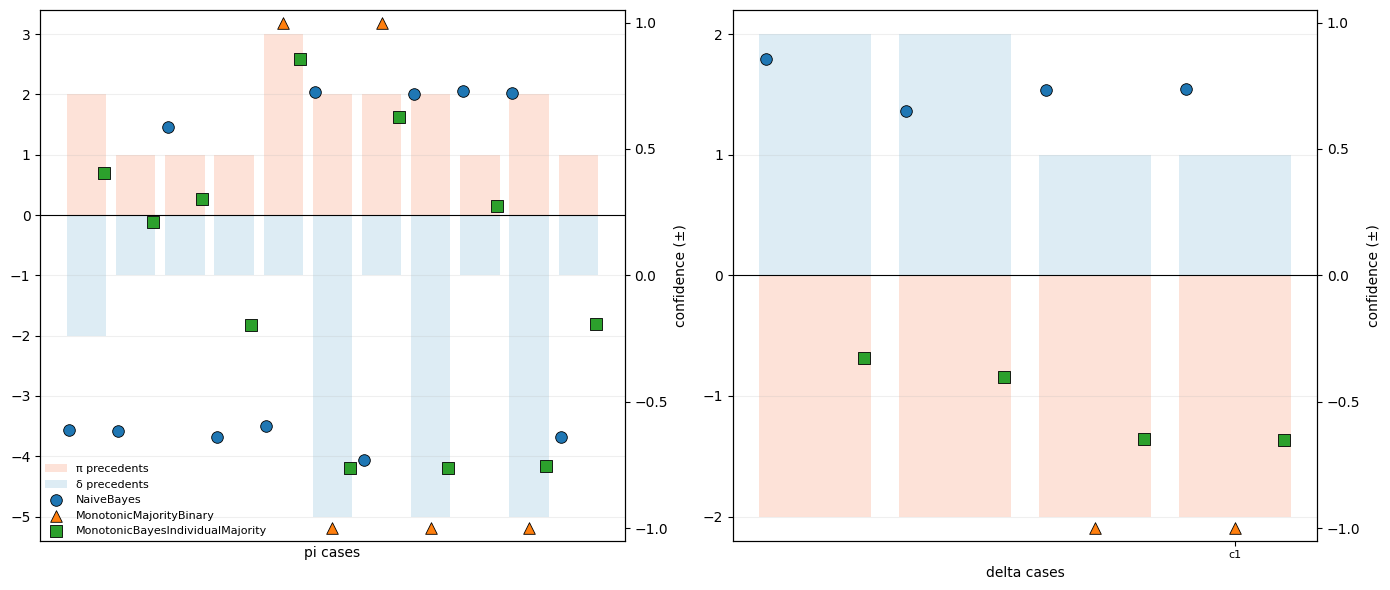

In [9]:
models=[MonotonicBayesIndividualLogOddsNoClipPriorChainMC1,MonotonicMajorityBinary, MonotonicBayesIndividualMajority]
df_disagree = plot_model_disagreement_with_precedents(hand_data2, models)

# Predictions of Naive Bayes ordered by confidence for the delta case, with histogram showing the precedents

In [12]:
# ------------------------- helpers -------------------------
def _all_subclasses(cls):
    direct = cls.__subclasses__()
    return set(direct).union(s for d in direct for s in _all_subclasses(d))

def _resolve_model_class(model):
    """
    Accept a class, or a string class name.
    Returns the class object (subclass of MonotonicModel).
    """
    if isinstance(model, type):
        return model
    if isinstance(model, str):
        try:
            subs = _all_subclasses(MonotonicModel)
        except NameError:
            raise RuntimeError("MonotonicModel must be defined in this session.")
        name2cls = {c.__name__: c for c in subs}
        if model not in name2cls:
            raise KeyError(f"Model '{model}' not found among subclasses of MonotonicModel.")
        return name2cls[model]
    raise TypeError("`model` must be a class or class name (str).")

def _parse_prediction(out):
    """
    Robustly parse the return of m.predict(test_case).
    Expected possibilities:
      ('pi'|'delta', conf) or ('pi'|'delta', conf, extra)
      'pi'|'delta'
      np.nan
    Returns (side or np.nan, conf or np.nan)
    """
    side, conf = np.nan, np.nan
    if isinstance(out, tuple):
        if len(out) >= 1:
            side = out[0]
        if len(out) >= 2 and isinstance(out[1], (int, float, np.floating)):
            conf = float(out[1])
    else:
        if isinstance(out, str) and out in {"pi", "delta"}:
            side, conf = out, 1.0
        else:
            side, conf = np.nan, np.nan
    return side, conf
def _precedent_counts(train_db, X):
    """
    Count precedents for a test set X within train_db:
      - pi_precedents:  # {S ⊆ X, conc='pi'}
      - delta_precedents: # {S ⊇ X, conc='delta'}
    """
    n_pi = n_de = 0
    for v in train_db.values():
        S, dec = v["set"], v["conclusion"]
        if dec == "pi" and S.issubset(X):
            n_pi += 1
        if dec == "delta" and S.issuperset(X):
            n_de += 1
    return n_pi, n_de


def plot_delta_histograms_for_model(
    data: dict,
    model,                  # class or class name (str)
    t: float | None = None, # optional confidence threshold; keep only conf >= t
    figsize=(8, 6),
    savepath: str = "case_histograms.png",
):
    """
    Leave-one-out plot for TRUE-δ cases only:
      +bar = # δ-precedents, −bar = # π-precedents (left y-axis)
      × at +conf if predicted δ, × at −conf if predicted π (right y-axis)

    X ticks and titles are removed; x-axis label is set to “δ cases”.
    Figure is saved as PNG to `savepath` (default: 'case_histograms.png').
    Returns the DataFrame used for plotting.
    """
    M = _resolve_model_class(model)

    cases = list(data.keys())
    rows = []
    for i, cid in enumerate(cases):
        train_db = {cases[j]: data[cases[j]] for j in range(len(cases)) if j != i}
        test_case = data[cid]
        X = test_case["set"]
        true_side = test_case["conclusion"]  # "pi" or "delta"

        m = M().fit(train_db)
        side, conf = _parse_prediction(m.predict(test_case))

        # keep only valid predictions (and pass threshold if provided)
        if not (isinstance(side, str) and side in {"pi", "delta"} and pd.notna(conf)):
            continue
        if t is not None and not (conf >= float(t)):
            continue

        n_pi, n_de = _precedent_counts(train_db, X)
        rows.append({
            "case": cid,
            "true": true_side,
            "pred": side,
            "conf": float(conf),
            "n_pi": int(n_pi),
            "n_delta": int(n_de),
        })

    if not rows:
        raise ValueError("No cases met the criteria (non-NaN predictions and threshold).")

    df = pd.DataFrame(rows)
    # keep TRUE-δ only, sorted by confidence (desc)
    df_del = df[df["true"] == "delta"].copy().sort_values("conf", ascending=False)
    if df_del.empty:
        raise ValueError("No TRUE-δ cases available after filtering.")

    # build arrays for bars and confidence signs
    pos_de  = df_del["n_delta"].to_numpy(dtype=float)
    neg_de  = -df_del["n_pi"].to_numpy(dtype=float)
    conf_de = np.where(df_del["pred"].values == "delta",
                       df_del["conf"].values,
                       -df_del["conf"].values)

    # symmetric count limits from this panel only
    all_counts = np.concatenate([pos_de, -neg_de])
    max_count = int(max(1, np.nanmax(np.abs(all_counts))))
    y_count_lim = max_count + max(1, max_count // 10)

    # plot single panel
    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True, facecolor="white")

    x = np.arange(len(conf_de))
    ax.bar(x, pos_de, width=0.8, label="+ δ precedents")
    ax.bar(x, neg_de, width=0.8, label="− π precedents")
    ax.axhline(0, color="k", linewidth=0.8)
    ax.set_ylim(-y_count_lim, y_count_lim)

    # remove x ticks/labels; set x-axis label
    ax.set_xticks([])
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax.set_xlabel(r"$\delta$ cases")
    ax.set_ylabel("Precedent count (±)")

    # overlay confidence on right y-axis
    ax2 = ax.twinx()
    ax2.scatter(x, conf_de, marker="x", s=35, linewidths=1.5, zorder=5)
    ax2.set_ylim(-1.05, 1.05)
    ax2.set_ylabel("Confidence (±)")

    # legend nudged a bit inward
    ax.legend(loc="upper right", bbox_to_anchor=(0.85, 0.75))

    # save (same default filename as your two-panel plot)
    plt.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

    return df_del


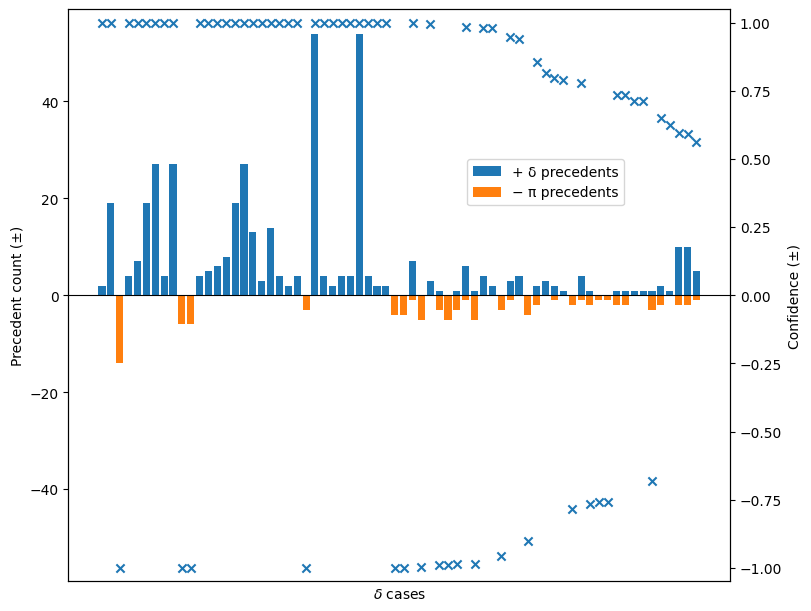

In [16]:
out = plot_delta_histograms_for_model(
    hand_data2,
    model="MonotonicBayesIndividualLogOddsNoClipPriorChainMC1",  # or pass the class itself
    t=None,              # or e.g. t=0.8 to filter by confidence

)


###F1 macro vs treshold on confidence



1.   The first evaluate models F1 score vs confidence treshold

2.   The second uses the output of the first to plot F1 vs coverage



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

# ---------------------------------------------------------------------
# Subclass discovery + resolver (names → classes, preserves order)
# ---------------------------------------------------------------------
def _all_subclasses(cls):
    direct = cls.__subclasses__()
    return set(direct).union(*( _all_subclasses(d) for d in direct ))

def _name_to_class_map():
    try:
        subs = all_subclasses(MonotonicModel)  # if you already defined one
    except NameError:
        subs = _all_subclasses(MonotonicModel)
    return {c.__name__: c for c in subs if not c.__name__.startswith("_")}

def _discover_individual_models(include_soft=True):
    name2cls = _name_to_class_map()
    keep = []
    for name, cls in name2cls.items():
        if name.startswith("MonotonicBayesIndividual") or (include_soft and "SoftVotes" in name):
            keep.append(cls)
    # dedupe + stable order
    return [c for _, c in sorted({c.__name__: c for c in keep}.items())]

def _resolve_model_classes(model_classes):
    """
    Accepts:
      • None → auto-discover individual models
      • list of classes
      • list of names (strings)
      • mixed list
    Returns a list of classes, de-duplicated, preserving first occurrence order.
    """
    if model_classes is None:
        return _discover_individual_models()

    name2cls = _name_to_class_map()
    resolved, seen = [], set()
    for m in model_classes:
        if isinstance(m, str):
            if m not in name2cls:
                avail = ", ".join(sorted(name2cls.keys()))
                raise KeyError(f"Model name '{m}' not found. Available: {avail}")
            cls = name2cls[m]
        elif isinstance(m, type):
            cls = m
        else:
            raise TypeError("model_classes must be a list of class objects or class names (strings).")
        if cls.__name__ not in seen:
            resolved.append(cls)
            seen.add(cls.__name__)
    return resolved

# ---------------------------------------------------------------------
# Helper: per-class F1 on the predicted subset (after confidence gating)
# ---------------------------------------------------------------------
def _class_f1(tp: int, fp: int, fn: int) -> float:
    den = 2 * tp + fp + fn
    return 100.0 * (2 * tp / den) if den > 0 else np.nan

# ---------------------------------------------------------------------
# Evaluate models at a single confidence threshold t → macro-F1 + coverage
# ---------------------------------------------------------------------
def eval_individual_models_with_conf_threshold_macro(data: dict, t: float, model_classes=None) -> pd.DataFrame:
    model_classes = _resolve_model_classes(model_classes)

    cases = list(data.keys())
    y_true = np.array([1 if data[c]["conclusion"] == "pi" else 0 for c in cases])

    rows = []
    for M in model_classes:
        pred_side, true_side = [], []

        for i, cid in enumerate(cases):
            # LOO split
            train_db = {cases[j]: data[cases[j]] for j in range(len(cases)) if j != i}
            test_case = data[cid]

            # fit + predict
            m = M()
            m.fit(train_db)
            out = m.predict(test_case)

            side = np.nan
            conf = np.nan

            # robust to different return shapes
            if isinstance(out, tuple):
                if len(out) >= 1:
                    side = out[0]
                if len(out) >= 2 and isinstance(out[1], (int, float, np.floating)):
                    conf = float(out[1])
            else:
                side = out
                if isinstance(side, str):
                    conf = 1.0

            # apply confidence gate
            if not (isinstance(side, str) and side in {"pi", "delta"} and pd.notna(conf) and conf >= t):
                side = np.nan

            pred_side.append(side)
            true_side.append("pi" if y_true[i] == 1 else "delta")

        pred_side = pd.Series(pred_side)
        true_side = pd.Series(true_side)

        # restrict to predicted items
        mask_pred = pred_side.isin(["pi", "delta"])
        n_total = len(true_side)
        n_kept  = int(mask_pred.sum())
        percent_pred_total = 100.0 * n_kept / n_total if n_total else np.nan

        ps = pred_side[mask_pred]
        ts = true_side[mask_pred]

        # confusion parts
        tp_pi = ((ps == "pi")    & (ts == "pi")).sum()
        fp_pi = ((ps == "pi")    & (ts == "delta")).sum()
        fn_pi = ((ps == "delta") & (ts == "pi")).sum()

        tp_de = ((ps == "delta") & (ts == "delta")).sum()
        fp_de = ((ps == "delta") & (ts == "pi")).sum()
        fn_de = ((ps == "pi")    & (ts == "delta")).sum()

        f1_pi = _class_f1(int(tp_pi), int(fp_pi), int(fn_pi))
        f1_de = _class_f1(int(tp_de), int(fp_de), int(fn_de))
        macro_f1 = np.nanmean([f1_pi, f1_de])

        rows.append({
            "model": M.__name__,
            "t": round(float(t), 3),
            "macro_f1": macro_f1,
            "percent_pred_total": percent_pred_total,
            "f1_pi": f1_pi,
            "f1_delta": f1_de,
            "n_predicted": n_kept,
        })

    return pd.DataFrame(rows)

# ---------------------------------------------------------------------
# Sweep confidence threshold and plot one panel per model:
#   macro-F1 (solid) and % predicted (dotted)
# ---------------------------------------------------------------------
def sweep_confidence_and_plot_macro(data: dict, model_classes=None, thresholds=None):
    model_classes = _resolve_model_classes(model_classes)

    if thresholds is None:
        thresholds = np.round(np.arange(0, 0.9901, 0.01), 2)  # inclusive

    # compute
    all_rows = []
    for t in thresholds:
        df_t = eval_individual_models_with_conf_threshold_macro(data, t=float(t), model_classes=model_classes)
        all_rows.append(df_t)

    results = pd.concat(all_rows, ignore_index=True)

    # plot
    n = len(model_classes)
    ncols = 2 if n > 1 else 1
    nrows = ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6.5 * ncols, 4.5 * nrows), squeeze=False)
    axes = axes.ravel()

    for idx, M in enumerate(model_classes):
        ax = axes[idx]
        name = M.__name__
        g = results[results["model"] == name].sort_values("t")

        x = g["t"].values
        ax.plot(x, g["macro_f1"].values, label="macro-F1", linewidth=2)
        ax.plot(x, g["percent_pred_total"].values, linestyle=":", linewidth=2, label="% predicted")

        ax.set_title(name)
        ax.set_xlabel(r"$t$ (min confidence to keep prediction)")
        ax.set_ylabel("Score (%)")
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=.25)
        ax.legend(loc="best")

    for k in range(len(model_classes), len(axes)):
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()

    return results


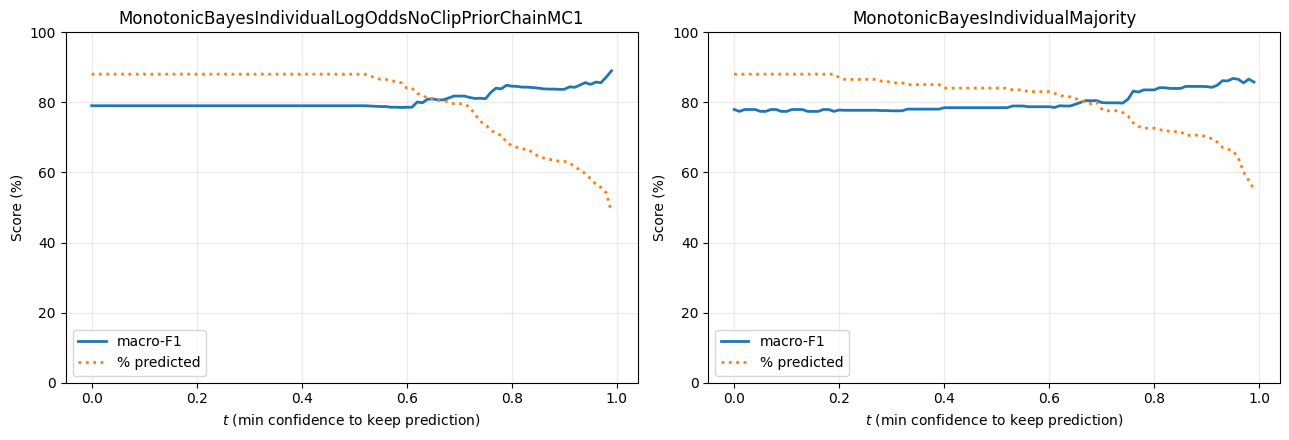

In [18]:
res_macro2 = sweep_confidence_and_plot_macro(hand_data2, model_classes=['MonotonicBayesIndividualLogOddsNoClipPriorChainMC1','MonotonicBayesIndividualMajority'])

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_macroF1_vs_coverage(
    results: pd.DataFrame,
    model_names = (
        "MonotonicBayesIndividualMajority",
        "MonotonicBayesIndividualWeighted",
        "MonotonicBayesIndividualSoftVotesMajority",
        "MonotonicBayesIndividualSoftVotesWeighted",
        "MonotonicBayesIndividualLogOdds",
        "MonotonicBayesIndividualLogOddsWeighted",
        # include the MC1 variant if it appears in your results:
        "MonotonicBayesIndividualLogOddsNoClipPriorChainMC1",
    ),
    annotate=False,                # set True to annotate a few t values
    annotate_ts=(0.50, 0.75, 0.90),
    save_path="macroF1_vs_coverage.png",
    # reference segments (feel free to tweak if you have updated figures)
    strict_cov=66.67,      # Strict Binary coverage (%)
    strict_f1=85.25,       # Strict Binary macro-F1 (%), used for the horizontal segment
    bim_ref_f1=78.49,      # Bayesian Individual Majority reference F1 (%)
    majority_cov=84.08     # Majority Binary coverage (%)
):
    """
    Plot macro-F1 vs. % predicted (coverage), one curve per model.
    Also draws two horizontal reference segments:
      • Strict Binary: y = strict_f1, x in [xmin, strict_cov]
      • BIM reference at Majority coverage: y = bim_ref_f1, x in [xmin, majority_cov]

    Expects columns in `results`: ["model","macro_f1","percent_pred_total"] (and optionally "t").
    """
    required_cols = {"model", "macro_f1", "percent_pred_total"}
    missing = required_cols - set(results.columns)
    if missing:
        raise ValueError(f"`results` is missing required columns: {sorted(missing)}")

    # Map internal model codes → paper names
    name_map = {
        "MonotonicBayesIndividualMajority": "Bayesian Individual Majority",
        "MonotonicBayesIndividualWeighted": "Bayesian Individual Majority (Weighted)",
        "MonotonicBayesIndividualSoftVotesMajority": "Soft Votes Majority",
        "MonotonicBayesIndividualSoftVotesWeighted": "Soft Votes Weighted",
        "MonotonicBayesIndividualLogOdds": "Naive Bayes",
        "MonotonicBayesIndividualLogOddsWeighted": "Naive Bayes (Weighted)",
        "MonotonicBayesIndividualLogOddsNoClipPriorChainMC1": "Naive Bayes (Chain+Prior, MC)",
    }

    # keep only requested models that are present
    avail = set(results["model"].unique())
    models_to_plot = [m for m in model_names if m in avail]
    if not models_to_plot:
        raise ValueError("None of the requested models are present in `results`.")

    fig, ax = plt.subplots(figsize=(8, 6))

    # plot curves
    for code_name in models_to_plot:
        g = results.loc[results["model"] == code_name].copy()
        g = g.dropna(subset=["macro_f1", "percent_pred_total"]).sort_values("percent_pred_total")

        x = g["percent_pred_total"].values
        y = g["macro_f1"].values

        # Style: dashed for Weighted variants
        paper_label = name_map.get(code_name, code_name)
        ls = "--" if "Weighted" in paper_label else "-"

        ax.plot(x, y, linestyle=ls, linewidth=2, label=paper_label)

        if annotate and "t" in g.columns:
            for t0 in annotate_ts:
                row = g.loc[np.isclose(g["t"].values, t0, atol=1e-6)]
                if not row.empty:
                    xx = float(row["percent_pred_total"].iloc[0])
                    yy = float(row["macro_f1"].iloc[0])
                    ax.scatter([xx], [yy], s=25)
                    ax.text(xx, yy, f" t={t0:.2f}", fontsize=9, ha="left", va="bottom")

    # axes, grid
    ax.set_xlabel("% of cases predicted")
    ax.set_ylabel("Macro-F1 (%)")
    # auto x-limits from data, with a small margin
    x_all = results["percent_pred_total"].dropna().values
    if len(x_all):
        xmin = max(0.0, float(np.nanmin(x_all) - 1.0))
        xmax = min(100.0, float(np.nanmax(x_all) + 1.0))
        ax.set_xlim(xmin, xmax)
    else:
        xmin, xmax = 10.0, 95.0
        ax.set_xlim(xmin, xmax)
    ax.set_ylim(70, 95)
    ax.grid(True, alpha=0.25)

    # reference segments (horizontal, truncated at target coverage)
    # Strict Binary reference
    x0 = xmin
    x1 = min(strict_cov, xmax)
    if x1 > x0:
        ax.plot([x0, x1], [strict_f1, strict_f1], color="gray", linestyle=":", linewidth=2,
                label=f"Strict Binary (to {strict_cov:.2f}%)")

    # BIM reference at Majority coverage
    x0_b = xmin
    x1_b = min(majority_cov, xmax)
    if x1_b > x0_b:
        ax.plot([x0_b, x1_b], [bim_ref_f1, bim_ref_f1], color="black", linestyle=":", linewidth=2,
                label=f"Bayesian Indiv. Majority @ F1={bim_ref_f1:.2f} (to {majority_cov:.2f}%)")

    # legend and save
    ax.legend(loc="best")
    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


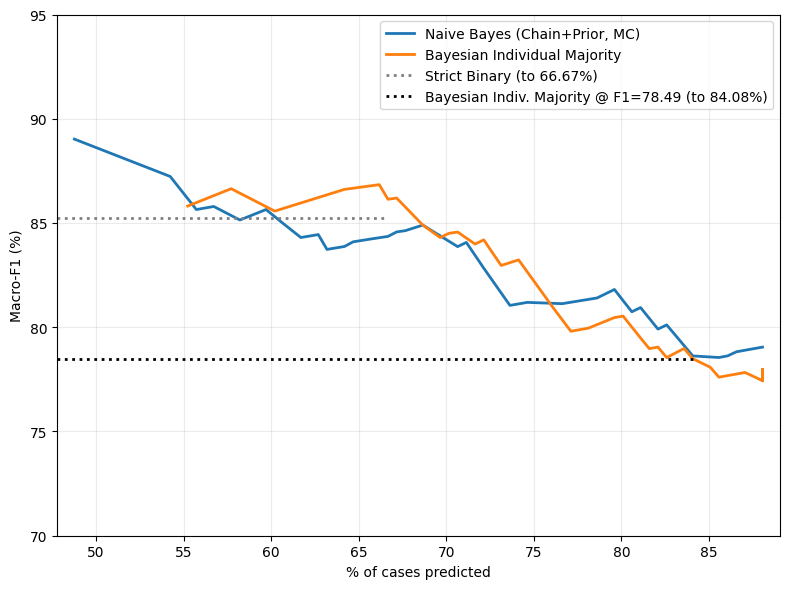

In [20]:
plot_macroF1_vs_coverage(res_macro2,['MonotonicBayesIndividualLogOddsNoClipPriorChainMC1','MonotonicBayesIndividualMajority'],annotate=False)

#30 80/20 splits

The 4 models evaluation on 80/20 splits


In [21]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List


#   MonotonicStrictBinary
#   MonotonicMajorityBinary
#   MonotonicBayesIndividualMajority
#   MonotonicBayesIndividualLogOddsNoClipPriorChainMC1

def _macro_f1(y_true: List[str], y_pred: List[str]) -> float:
    """
    Macro-F1 for labels in {'pi','delta'}.
    If a class is missing in y_pred AND y_true for this slice, its F1 is 0.
    """
    labels = ('pi', 'delta')
    f1s = []
    for c in labels:
        tp = sum((yt == c) and (yp == c) for yt, yp in zip(y_true, y_pred))
        fp = sum((yt != c) and (yp == c) for yt, yp in zip(y_true, y_pred))
        fn = sum((yt == c) and (yp != c) for yt, yp in zip(y_true, y_pred))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        f1s.append(f1)
    return float(np.mean(f1s))

def _predict_label(pred_out):
    """
    Normalize model.predict output to {'pi','delta', None}.
    Most of your models return either:
      ('pi', conf) / ('delta', conf)  or  (np.nan, np.nan)
    """
    if isinstance(pred_out, tuple) and len(pred_out) >= 1:
        lab = pred_out[0]
        if isinstance(lab, str):
            return lab
        else:
            return None
    if isinstance(pred_out, str):
        return pred_out
    return None

def _random_split_keys(keys: List[str], test_ratio: float, rng: np.random.Generator):
    idx = np.arange(len(keys))
    rng.shuffle(idx)
    cut = int((1.0 - test_ratio) * len(keys))
    train_idx, test_idx = idx[:cut], idx[cut:]
    train_keys = [keys[i] for i in train_idx]
    test_keys  = [keys[i] for i in test_idx]
    return train_keys, test_keys

def evaluate_four_models(
    full_db: Dict[str, dict],
    *,
    n_splits: int = 30,
    test_ratio: float = 0.2,
    base_seed: int = 13,
    mc_draws: int = 20000
) -> pd.DataFrame:
    """
    full_db: mapping case_id -> {'set': set(...), 'conclusion': 'pi'|'delta'}
    Returns a pandas DataFrame with mean metrics over splits.
    """

    # Model factories (fresh instance per split)
    def make_models(seed: int):
        return {
            "Strict Binary":
                MonotonicStrictBinary(),
            "Binary Majority":
                MonotonicMajorityBinary(),
            "Bayesian Individual Majority":
                MonotonicBayesIndividualMajority(draws=mc_draws, random_state=seed),
            "Naive-Bayes Log-Odds (Chain+Prior, MC)":
                MonotonicBayesIndividualLogOddsNoClipPriorChainMC1(draws=mc_draws, random_state=seed),
        }

    # Accumulators
    records = {name: {"coverage_pct": [], "macroF1_pred_only": [], "macroF1_completed_pi": []}
               for name in make_models(base_seed).keys()}

    keys_all = list(full_db.keys())
    rng_global = np.random.default_rng(base_seed)

    for split_idx in range(n_splits):
        # ---- split
        seed = int(base_seed + split_idx)
        rng = np.random.default_rng(seed)
        train_keys, test_keys = _random_split_keys(keys_all, test_ratio, rng)

        train_db = {k: full_db[k] for k in train_keys}
        test_db  = {k: full_db[k]  for k in test_keys}

        # ---- train models
        models = make_models(seed)
        for m in models.values():
            m.fit(train_db)

        # ---- evaluate on test
        y_true_all = [test_db[k]["conclusion"] for k in test_keys]

        for name, model in models.items():
            preds: List[str | None] = []
            for k in test_keys:
                case = test_db[k]
                out = model.predict(case)
                preds.append(_predict_label(out))

            # coverage
            n_pred = sum(p is not None for p in preds)
            n_tot  = len(preds)
            coverage_pct = 100.0 * n_pred / n_tot if n_tot else 0.0

            # macro-F1 on predicted-only
            mask = [p is not None for p in preds]
            if any(mask):
                y_true_predonly = [yt for yt, keep in zip(y_true_all, mask) if keep]
                y_pred_predonly = [p  for p,  keep in zip(preds, mask)      if keep]  # type: ignore
                f1_predonly = _macro_f1(y_true_predonly, y_pred_predonly)   # macro
            else:
                f1_predonly = np.nan  # undefined if model abstains on everything

            # macro-F1 after completing abstentions with 'pi'
            y_pred_completed = [p if p is not None else "pi" for p in preds]
            f1_completed = _macro_f1(y_true_all, y_pred_completed)

            # store
            records[name]["coverage_pct"].append(coverage_pct)
            records[name]["macroF1_pred_only"].append(f1_predonly)
            records[name]["macroF1_completed_pi"].append(f1_completed)

    # ---- aggregate to a table (mean over splits; ignore NaNs in pred-only F1)
    rows = []
    for name, mets in records.items():
        cov_mean = float(np.mean(mets["coverage_pct"])) if mets["coverage_pct"] else np.nan
        f1po_arr = np.array(mets["macroF1_pred_only"], dtype=float)
        f1po_mean = float(np.nanmean(f1po_arr)) if f1po_arr.size else np.nan
        f1c_mean = float(np.mean(mets["macroF1_completed_pi"])) if mets["macroF1_completed_pi"] else np.nan

        rows.append({
            "Model": name,
            "Coverage % (mean)": round(cov_mean, 2),
            "Macro-F1 on predicted only (mean)": round(f1po_mean, 4) if not np.isnan(f1po_mean) else np.nan,
            "Macro-F1 with π-completion (mean)": round(f1c_mean, 4),
        })

    df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)
    return df


In [22]:


table = evaluate_four_models(hand_data2, n_splits=30, test_ratio=0.2, base_seed=42, mc_draws=20000)
print(table)


                                    Model  Coverage % (mean)  \
0            Bayesian Individual Majority              85.93   
1                         Binary Majority              82.93   
2  Naive-Bayes Log-Odds (Chain+Prior, MC)              85.93   
3                           Strict Binary              68.70   

   Macro-F1 on predicted only (mean)  Macro-F1 with π-completion (mean)  
0                             0.7809                             0.7512  
1                             0.7862                             0.7505  
2                             0.7828                             0.7535  
3                             0.8411                             0.7331  
